```
This software is a part of GPU Ocean.

Copyright (C) 2019  SINTEF Digital

This notebook is a prototype for ensuring that the model error works
on real-world simulations.

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
```

In [4]:
#Lets have matplotlib "inline"
%matplotlib inline
#%config InlineBackend.figure_format = 'retina'

import os
import sys

#Import packages we need
import numpy as np
from netCDF4 import Dataset

#Helpful during development
import importlib
#importlib.reload(module)

import datetime

from matplotlib import animation, rc, colors, colorbar
from matplotlib import pyplot as plt

from IPython.display import display
from IPython.display import Video

#Set large figure sizes
#plt.rcParams["animation.html"] = "jshtml" #Javascript 
plt.rcParams["animation.html"] = "html5" #mp4
plt.rcParams["figure.dpi"] = 100.0 #highres movies/plots

plt.rcParams["animation.writer"] = 'ffmpeg' 
plt.rcParams["animation.codec"] = 'h264' 

plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = 'serif'

In [5]:
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../../')))

from SWESimulators import CDKLM16, PlotHelper, Common, WindStress, OceanStateNoise
from SWESimulators import IPythonMagic, OceanographicUtilities, NetCDFInitialization


In [6]:
%cuda_context_handler gpu_ctx

In [7]:
#Set this to false before comitting to only get images
create_movie = False
movie_frames = 200
download_data = True
timestep_indices = None

# Select area and result folder

In [8]:
#case = 1 # Open waters in the Norwegian Sea
#case = 2 # Lofoten
#case = 3 # The Norwegian Coast
case = 4 # Southern Norway

casename = 'norwegian_sea_'

if case == 2:
    casename = 'lofoten_'
    
if case == 3:
    casename = 'complete_coast_'

if case == 4:
    casename = 'southern_norway_'
    

folder = os.path.join('moderr', casename+datetime.datetime.now().strftime("%Y_%m_%d"))

assert(folder.find(casename) > -1), 'folder does contain casename: '+folder

os.makedirs(folder, exist_ok=True)
print(folder)

moderr\southern_norway_2019_11_07


# Misc helper functions

In [9]:
def plotSolution(fig, 
                 eta, hu, hv, h, dx, dy, 
                 t, comment,
                 h_min=-1.5, h_max=1.5, 
                 uv_min=-0.05, uv_max=0.05, 
                 add_extra=0,
                 ax=None, sp=None,
                 rotate=False, downsample=None):    
    from datetime import timedelta
    fig.suptitle("Time = {:0>8} ({:s})".format(str(timedelta(seconds=int(t))), comment), 
                 fontsize=18,
                 horizontalalignment='left')
    
    x_plots = 1
    y_plots = 1
    
    if (downsample is not None):
        eta = eta[::downsample, ::downsample]
        h = h[::downsample, ::downsample]
        hu = hu[::downsample, ::downsample]
        hv = hv[::downsample, ::downsample]
    
    if (add_extra == 1):
        x_plots=3
        y_plots=1
    elif (add_extra == 2):
        x_plots=3
        y_plots=2
        
    if (add_extra == 2):
        V_max = 5 * (uv_max-uv_min) / np.max(h)
        R_min = -V_max/2
        R_max = V_max/2
        
        V = PlotHelper.genVelocity(h, hu, hv)
        R = PlotHelper.genColors(h, hu, hv, plt.cm.seismic, R_min, R_max)
            
    ny, nx = eta.shape
    if (rotate):
        domain_extent = [0, ny*dy/1000, 0, nx*dx/1000]
        eta = np.rot90(eta, 3)
        h = np.rot90(h, 3)
        hu = np.rot90(hu, 3)
        hv = np.rot90(hv, 3)
        
        if (add_extra == 2):
            V = np.rot90(V, 3)
            R = np.rot90(R, 3)
    else:
        domain_extent = [0, nx*dx/1000, 0, ny*dy/1000]
    
    

    if (ax is None):
        ax = [None]*x_plots*y_plots
        sp = [None]*x_plots*y_plots
        
        ax[0] = plt.subplot(y_plots, x_plots, 1)
        sp[0] = ax[0].imshow(eta, interpolation="none", origin='bottom', 
                             cmap=plt.cm.coolwarm, 
                             vmin=h_min, vmax=h_max, 
                             extent=domain_extent)
        plt.colorbar(sp[0], shrink=0.9)
        plt.axis('image')
        plt.title("$\eta{}$")
        
        if (add_extra > 0):
            ax[1] = plt.subplot(y_plots, x_plots, 2)
            sp[1] = ax[1].imshow(hu, interpolation="none", origin='bottom', 
                                 cmap=plt.cm.coolwarm, 
                                 vmin=uv_min, vmax=uv_max, 
                                 extent=domain_extent)
            plt.colorbar(sp[1], shrink=0.9)
            plt.axis('image')
            plt.title("$hu$")

            ax[2] = plt.subplot(y_plots, x_plots, 3)
            sp[2] = ax[2].imshow(hv, interpolation="none", origin='bottom', 
                                 cmap=plt.cm.coolwarm, 
                                 vmin=uv_min, vmax=uv_max, 
                                 extent=domain_extent)
            plt.colorbar(sp[2], shrink=0.9)
            plt.axis('image')
            plt.title("$hv$")

        if (add_extra > 1):
            ax[3] = plt.subplot(y_plots, x_plots, 4)
            sp[3] = ax[3].imshow(V, interpolation="none", origin='bottom', 
                               cmap=plt.cm.Oranges, 
                               vmin=0, vmax=V_max, 
                               extent=domain_extent)
            plt.colorbar(sp[3], shrink=0.9)
            plt.axis('image')
            plt.title("Particle velocity magnitude")

            ax[4] = plt.subplot(y_plots, x_plots, 5)
            sp[4] = ax[4].imshow(R, interpolation="none", 
                               origin='bottom', 
                               extent=domain_extent)
            sm = plt.cm.ScalarMappable(norm=colors.Normalize(vmin=R_min, vmax=R_max), cmap=plt.cm.seismic)
            sm.set_array([])
            fig.colorbar(sm, shrink=0.9)
            #colorbar.Colorbar(ax[4], cmap=plt.cm.seismic, mappable=plt.cm.ScalarMappable(norm=colors.Normalize(vmin=R_min, vmax=R_max), cmap=plt.cm.seismic)colors.Normalize(vmin=R_min, vmax=R_max), orientation='horizontal', shrink=0.9)
            plt.axis('image')
            plt.title("Vorticity magnitude")
            
    else:        
        #Update plots
        fig.sca(ax[0])
        sp[0].set_data(eta)
        
        if (add_extra > 0):
            fig.sca(ax[1])
            sp[1].set_data(hu)

            fig.sca(ax[2])
            sp[2].set_data(hv)
        
        if (add_extra > 1):
            fig.sca(ax[3])
            sp[3].set_data(V)

            fig.sca(ax[4])
            sp[4].set_data(R)
    
    return ax, sp

# Inspect URL and select area

In [11]:
nordic4km_url = 'http://thredds.met.no/thredds/dodsC/fou-hi/nordic4km-1h/Nordic-4km_SURF_1h_avg_00.nc'
norkyst800_url = 'https://thredds.met.no/thredds/dodsC/fou-hi/norkyst800m-1h/NorKyst-800m_ZDEPTHS_his.an.2019071600.nc'

source_url = norkyst800_url

In [60]:
download_data=True
if (download_data):
    cache_folder = 'netcdf_cache'
    os.makedirs(cache_folder, exist_ok=True)

    filename = os.path.abspath(os.path.join(cache_folder, os.path.basename(source_url)))
    
    if (os.path.isfile(filename)):
        source_url = filename
    
    else:
        import requests
        download_url = source_url.replace("dodsC", "fileServer")

        req = requests.get(download_url, stream = True)
        filesize = int(req.headers.get('content-length'))

        progress = Common.ProgressPrinter()
        pp = display(progress.getPrintString(0),display_id=True)

        print("Downloading data to local file (" + str(filesize // (1024*1024)) + " MB)")
        with open(filename, "wb") as outfile:
            for chunk in req.iter_content(chunk_size = 10*1024*1024):
                if chunk:
                    outfile.write(chunk)
                    pp.update(progress.getPrintString(outfile.tell() / filesize))

        source_url = filename
        
print("Source is : " + source_url)

Source is : C:\Users\havardh\playground\gpu-ocean\havahol-gpu-ocean\gpu_ocean\demos\mpisir\netcdf_cache\NorKyst-800m_ZDEPTHS_his.an.2019071600.nc


In [81]:
##### 
case2_x0 = 1400
case2_x1 = int(case2_x0 + 500)
case2_y0 = 450
case2_y1 = int(case2_y0 + 300)

#x0 = 1650
#x1 = int(x0 + 100)
#y0 = 450
#y1 = int(y0 + 200)

case1_x0 = 900
case1_x1 = 1400
case1_y0 = 600
case1_y1 = 875


case3_x0 = 25
case3_x1 = 2575
case3_y0 = 25
case3_y1 = 875

case4_x0 = 25
case4_x1 = 500-1
case4_y0 = 25
case4_y1 = 800-1

In [82]:
## Select case

x0 = case1_x0
x1 = case1_x1
y0 = case1_y0
y1 = case1_y1

if case == 2:
    x0 = case2_x0
    x1 = case2_x1
    y0 = case2_y0
    y1 = case2_y1
    print('using the Lofoten case')

elif case == 3:
    x0 = case3_x0
    x1 = case3_x1
    y0 = case3_y0
    y1 = case3_y1
    print('using the complete coast case')

elif case == 4:
    x0 = case4_x0
    x1 = case4_x1
    y0 = case4_y0
    y1 = case4_y1
    print('using the southern coast case')


    
else:
    print('using Norwegian Sea area')


using the southern coast case


# Plot areas

(902, 2602)


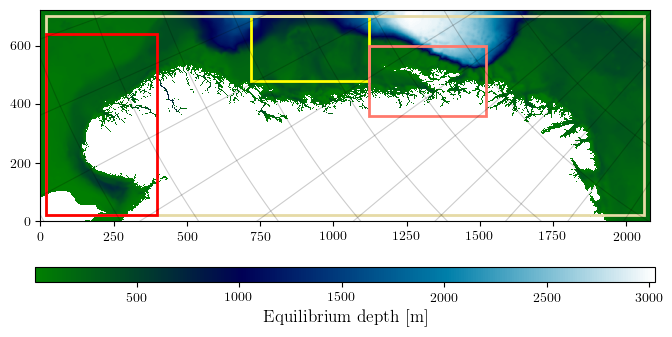

In [83]:
try:
    ncfile = Dataset(source_url)
    H_full = np.array(ncfile.variables['h'])
    angle = np.array(ncfile.variables['angle'])
    print(H_full.shape)
    lat = np.array(ncfile.variables["lat"])
    lon = np.array(ncfile.variables["lon"])
except Exception as e:
    raise e

finally:
    ncfile.close()


land_value = H_full.min()
(full_ny, full_nx) = H_full.shape

# Makes sure axis are in km (assuming equidistant 800x800m grid)
extent=np.array([0, full_nx*0.8, 0, full_ny*0.8])


fig = plt.figure(figsize=(8,4))
# Land and bathymetry
land = np.ma.masked_where(H_full == land_value, H_full)
im = plt.imshow(land, interpolation="None", origin='lower', cmap='ocean',
           extent=extent)

cbar = fig.colorbar(im, orientation='horizontal', aspect=40)
cbar.set_label('Equilibrium depth [m]', size=12.5)


# Case boxes
fig.gca().fill(np.array([case1_x0, case1_x0, case1_x1, case1_x1])*0.8, 
               np.array([case1_y0, case1_y1, case1_y1, case1_y0])*0.8, 
               fill=False, linestyle='-', linewidth=2, color='yellow')
fig.gca().fill(np.array([case2_x0, case2_x0, case2_x1, case2_x1])*0.8, 
               np.array([case2_y0, case2_y1, case2_y1, case2_y0])*0.8, 
               fill=False, linestyle='-', linewidth=2, color='xkcd:salmon')
fig.gca().fill(np.array([case3_x0, case3_x0, case3_x1, case3_x1])*0.8, 
               np.array([case3_y0, case3_y1, case3_y1, case3_y0])*0.8, 
               fill=False, linestyle='-', linewidth=2, color='xkcd:beige')
fig.gca().fill(np.array([case4_x0, case4_x0, case4_x1, case4_x1])*0.8, 
               np.array([case4_y0, case4_y1, case4_y1, case4_y0])*0.8, 
               fill=False, linestyle='-', linewidth=2, color='red')


plt.contour(lon, levels = np.arange(0, 40, 4), extent=extent, colors='k', alpha=0.2, linewidths=0.8)
plt.contour(lat, levels = np.arange(56,77, 2), extent=extent, colors='k', alpha=0.2, linewidths=0.8)

                                                                                    
                                                                                            


# Look at model error terms

In [353]:
def plot_state(sim, zoom_mode=0, apply_mask=True):
    eta, hu, hv = sim.download(interior_domain_only=True)
    Hi, Hm = sim.downloadBathymetry(interior_domain_only=True)

    if not apply_mask:
        eta = sim.gpu_data.h0.data.get(stream=sim.gpu_stream)[80:-80, 80:-80]
        hu = sim.gpu_data.hu0.data.get(stream=sim.gpu_stream)[80:-80, 80:-80]
        hv = sim.gpu_data.hv0.data.get(stream=sim.gpu_stream)[80:-80, 80:-80]
        #hv = sim.bathymetry.Bm.data.get(stream=sim.gpu_stream)[80:-80, 80:-80]
    
    eta_max = max(np.max(np.abs(eta)), 0.0001)
    huv_max = max(np.max(np.abs(hu)), np.max(np.abs(hv)), 0.01)
    print('eta_max: ', eta_max)
    print('huv_max: ', huv_max)
    fig = plt.figure(figsize=(14, 4))
    if zoom_mode > 0:
        # zoom_mode 1:
        x_start = 85
        x_end   = 105
        y_start = 270
        y_end   = 300
        
        # Zoom
        eta = eta[y_start:y_end, x_start:x_end]
        hu  =  hu[y_start:y_end, x_start:x_end]
        hv  =  hv[y_start:y_end, x_start:x_end]
        Hm  =  Hm[y_start:y_end, x_start:x_end]
        
    
    plotSolution(fig, eta, hu, hv, Hm+eta,
                 sim.dx, sim.dy, sim.t, 
                 'initial conditions', 
                 rotate=True, add_extra=1, 
                 h_max=eta_max, h_min=-eta_max, uv_max=huv_max, uv_min=-huv_max)

In [405]:
# Create initial conditions from NetCDF
data_args = NetCDFInitialization.getInitialConditions(source_url, x0, x1, y0, y1, timestep_indices=timestep_indices)

In [414]:
# Set other initial condition parameters 
sim_args = {
    "gpu_ctx": gpu_ctx,
    "dt": 0.0,
    "rk_order": 2,
    "desingularization_eps": 1.0,
    "small_scale_perturbation": True,
    "small_scale_perturbation_amplitude": 1.0e-5, #1.0e-5,
    "small_scale_perturbation_interpolation_factor": 5
}



In [415]:
# Enforcing lake at rest (lar)
lar_args = data_args.copy()
#for key, value in lar_args.items():
#    print(key)

lar_args['eta0'] = np.zeros_like(lar_args['eta0'])
lar_args['hu0']  = np.zeros_like(lar_args['hu0'])
lar_args['hv0']  = np.zeros_like(lar_args['hv0'])

zero_bc = False
if zero_bc:
    lar_args['boundary_conditions_data'].north.h  = np.zeros_like(lar_args['boundary_conditions_data'].north.h)
    lar_args['boundary_conditions_data'].north.hu = np.zeros_like(lar_args['boundary_conditions_data'].north.hu)
    lar_args['boundary_conditions_data'].north.hv = np.zeros_like(lar_args['boundary_conditions_data'].north.hv)
    
    lar_args['boundary_conditions_data'].south.h  = np.zeros_like(lar_args['boundary_conditions_data'].south.h)
    lar_args['boundary_conditions_data'].south.hu = np.zeros_like(lar_args['boundary_conditions_data'].south.hu)
    lar_args['boundary_conditions_data'].south.hv = np.zeros_like(lar_args['boundary_conditions_data'].south.hv)
    
    lar_args['boundary_conditions_data'].east.h  = np.zeros_like(lar_args['boundary_conditions_data'].east.h)
    lar_args['boundary_conditions_data'].east.hu = np.zeros_like(lar_args['boundary_conditions_data'].east.hu)
    lar_args['boundary_conditions_data'].east.hv = np.zeros_like(lar_args['boundary_conditions_data'].east.hv)
    
    lar_args['boundary_conditions_data'].west.h  = np.zeros_like(lar_args['boundary_conditions_data'].west.h)
    lar_args['boundary_conditions_data'].west.hu = np.zeros_like(lar_args['boundary_conditions_data'].west.hu)
    lar_args['boundary_conditions_data'].west.hv = np.zeros_like(lar_args['boundary_conditions_data'].west.hv)

print('sim.ny, sim.nx', lar_args['ny'], lar_args['nx'])


sim.ny, sim.nx 614 314


In [416]:
if 'sim' in globals():
    sim.cleanUp()
    
importlib.reload(OceanStateNoise)
importlib.reload(CDKLM16)

#sim = CDKLM16.CDKLM16(**sim_args, **NetCDFInitialization.removeMetadata(lar_args))
sim = CDKLM16.CDKLM16(**sim_args, **NetCDFInitialization.removeMetadata(data_args))
#plot_state(sim)

from OceanStateNoise
(ny, nx) (770, 470)
interpolation_factor 5
--- end OceanStateNoise


In [417]:
#sim.perturbState()
num_perturbations = 1
for i in range(num_perturbations):
    sim.perturbState()

eta_max:  0.28401074
huv_max:  82.21
eta_max:  0.28401074
huv_max:  160.43474


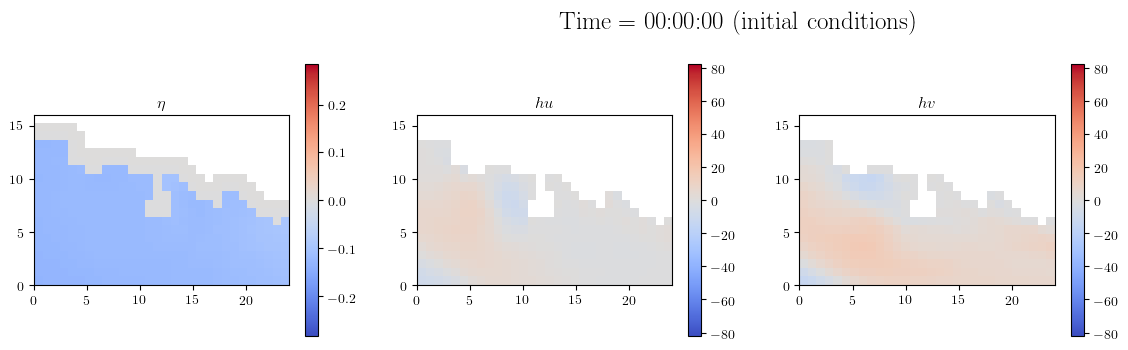

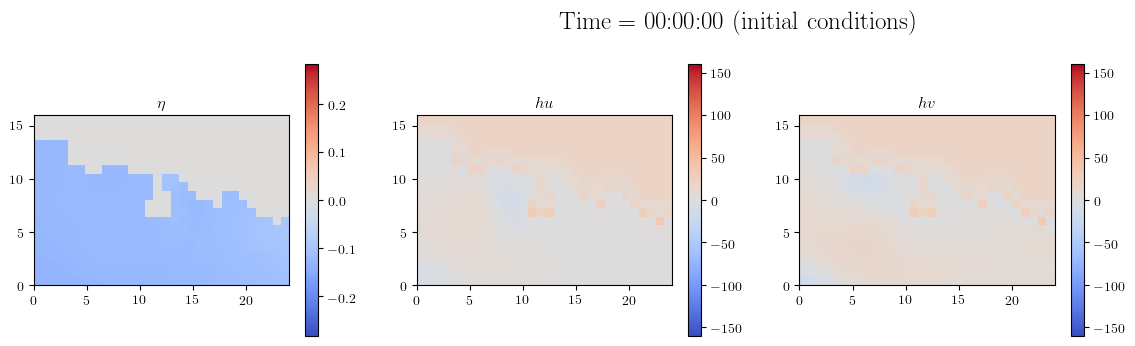

In [418]:
plot_state(sim, zoom_mode=1)
plot_state(sim, zoom_mode=1, apply_mask=False)

In [419]:
sim.step(sim.dt, apply_stochastic_term=False)


1.9304502487182624

In [420]:
sim.step(6*60*60, apply_stochastic_term=True)
print(sim.dt)

1.9304502487182618


eta_max:  0.55806047
huv_max:  100.47542
eta_max:  0.55806047
huv_max:  100.47542
eta_max:  0.55806047
huv_max:  100.47542


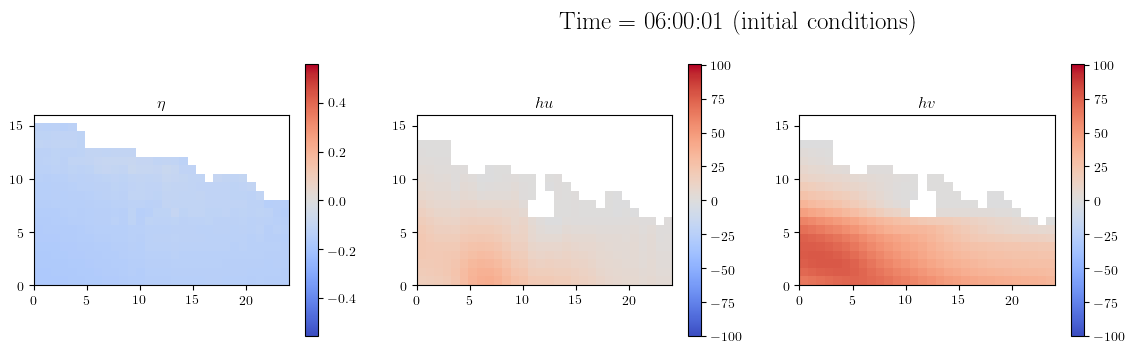

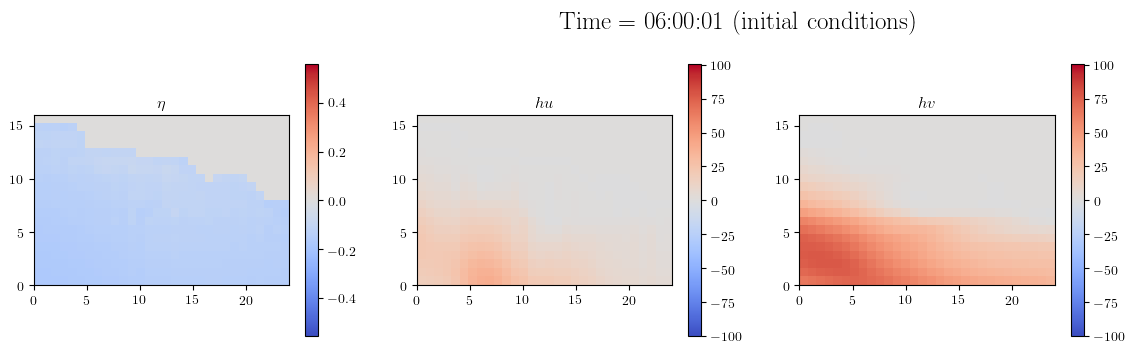

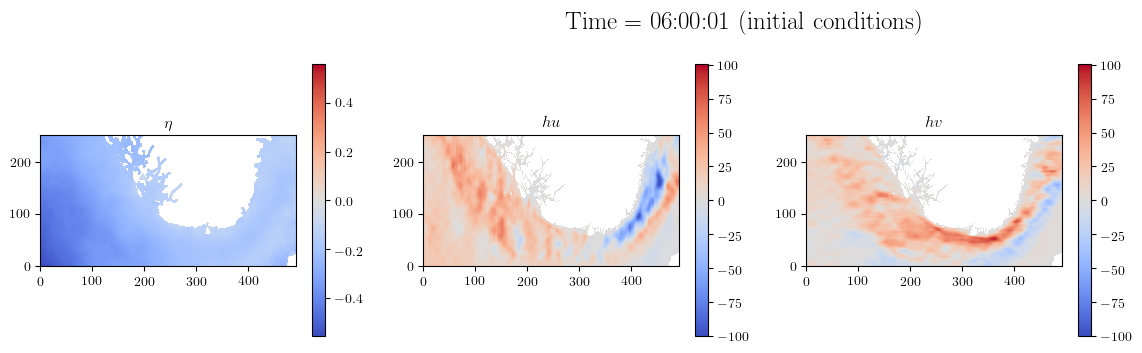

In [421]:
plot_state(sim, zoom_mode=1)
plot_state(sim, zoom_mode=1, apply_mask=False)
plot_state(sim)

(774, 474)
(614, 314)
160 160
<class 'numpy.ndarray'>


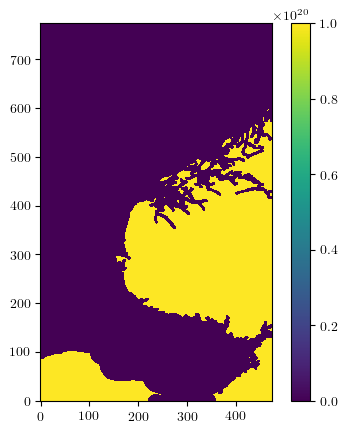

In [396]:
eta, hu, hv = sim.download(interior_domain_only=True)

eta = sim.gpu_data.h0.data.get(stream=sim.gpu_stream)
eta = sim.bathymetry.Bm.data.get(stream=sim.gpu_stream)

print(eta.shape)
print(hu.shape)
print(eta.shape[0]-hu.shape[0], eta.shape[1]-hu.shape[1])

print(type(eta))

fig = plt.figure(figsize=(5,5))
plt.imshow(eta, origin='lower')
plt.colorbar()

Problems:

- [x] Landmask
- [x] Varying H
- [ ] Boundary conditions
- [ ] Varying north vector
